# Import Files

In [1]:
# setup workspace
%matplotlib inline

import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import io
import csv
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_validate, train_test_split, cross_val_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import imblearn
from collections import Counter

In [2]:
df = pd.read_csv("EXPORT_DATASET.csv")

# Balance Data (SMOTE)

In [3]:
X = df.drop('RESPONSE', axis=1)
y = df['RESPONSE']

In [4]:
# import library
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 43358, 1: 575})
Resample dataset shape Counter({0: 43358, 1: 43358})


# Features

In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [6]:
X = x_smote
y = y_smote

In [7]:
fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(X, y)

SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x000002C3EAA79F70>)

<Figure size 576x576 with 0 Axes>

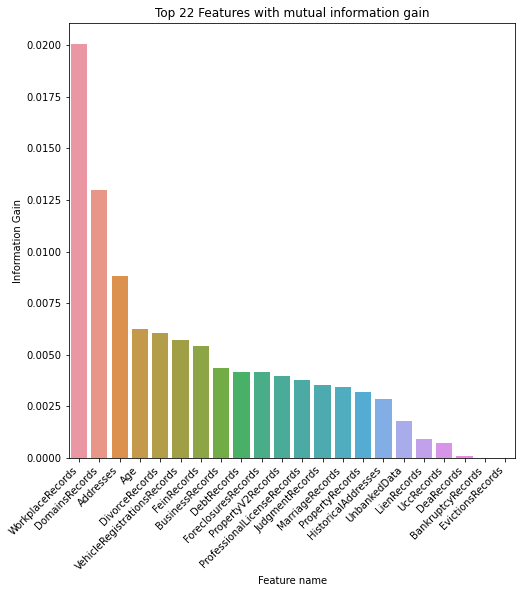

In [8]:
feature_imp = pd.DataFrame(fs.scores_, columns=['Score'], index=X.columns)
top22_feature = feature_imp.nlargest(n=22, columns=['Score'])

plt.figure(figsize=(8,8))
g = sns.barplot(x=top22_feature.index, y=top22_feature['Score'])
p = plt.title('Top 22 Features with mutual information gain')
p = plt.xlabel('Feature name')
p = plt.ylabel('Information Gain')
p = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

<Figure size 1080x1080 with 0 Axes>

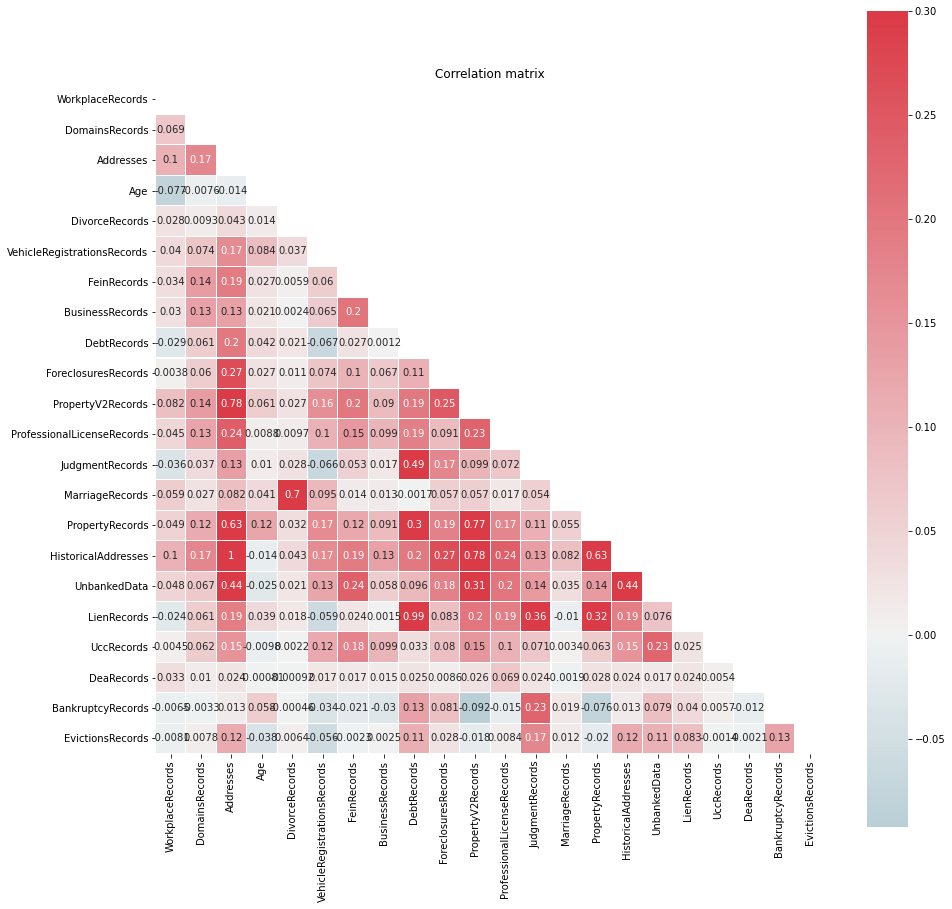

In [9]:
# Finding and plotting the correlation matrix for top22 features

cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(15, 15))
corr = X[top22_feature.index].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

g = sns.heatmap(corr, annot=True, mask=mask, vmax=0.3, center=0, cmap=cmap, square=True, linewidths=0.05)
p = plt.title('Correlation matrix')

# Random Forest

In [10]:
# Load required
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create train/test split and calculate base MAE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

# Initialize base RandomForestClassifier model 
rf_clf = RandomForestClassifier()

In [11]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [12]:
# List the importance of each feature
col_names = df.drop(columns=["RESPONSE"]).columns
fi_df = pd.DataFrame(rf_clf.feature_importances_, index=col_names, columns=["Importance"])

fi_df.sort_values("Importance", ascending=False)

,Importance
Age,0.167079
PropertyRecords,0.132097
HistoricalAddresses,0.080698
VehicleRegistrationsRecords,0.079693
Addresses,0.079601
PropertyV2Records,0.066436
UnbankedData,0.057440
DebtRecords,0.057318
LienRecords,0.043095
JudgmentRecords,0.041759


In [13]:
# Baseline model performance
scores = cross_val_score(rf_clf, X_train, y_train, cv=5)
avg_cv = round(scores.mean(),3)
print("all scores: ", scores)
print("average score: ", avg_cv)

all scores:  [0.97755228 0.98016605 0.97870377 0.9790113  0.9807027 ]
average score:  0.979


In [14]:
# Initialize random forest hyperparameter tuning with grid search
param_grid = {
    "n_estimators":[50],
    "max_depth":[100],
    "max_features":[10,50,100],
    "min_samples_leaf":[2],
    #"bootstrap":[True, False],
    "criterion":["gini", "entropy"]
}

rf_clf = RandomForestClassifier()
rf_clf_tuned = GridSearchCV(estimator=rf_clf,
                                param_grid=param_grid,
                                cv=5,
                                n_jobs=-1,
                                verbose=2)

rf_clf_tuned.fit(X_train, y_train)
rf_clf_tuned.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [100],
                         'max_features': [10, 50, 100], 'min_samples_leaf': [2],
                         'n_estimators': [50]},
             verbose=2)

RandomForestClassifier(criterion='entropy', max_depth=100, max_features=10,
                       min_samples_leaf=2, n_estimators=50)

In [15]:
# Fit model with best parameters
rf_clf = RandomForestClassifier(criterion='entropy',
                           max_depth=500,
                           max_features=14,
                           min_samples_leaf=4,
                           n_estimators=10)
rf_clf.fit(X_train, y_train)
scores = cross_val_score(rf_clf, X_train, y_train, cv=5)
avg_cv = round(scores.mean(),3)
print("\n")
print("All scores: ", scores)
print("Average score: ", avg_cv)

RandomForestClassifier(criterion='entropy', max_depth=500, max_features=14,
                       min_samples_leaf=4, n_estimators=10)



All scores:  [0.95841021 0.96140836 0.95617744 0.95579303 0.9605597 ]
Average score:  0.958


In [16]:
#check accuracy
print (f'Train Accuracy: {rf_clf.score(X_train,y_train):.3f}')
print (f'Test Accuracy: {rf_clf.score(X_test,y_test):.3f}')

Train Accuracy: 0.988
Test Accuracy: 0.967


In [17]:
#confusion matrix of predictions
predictions = rf_clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("\n--------------------------")

print("\nClassification Report:")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[10402   503]
 [  217 10557]]

--------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     10905
           1       0.95      0.98      0.97     10774

    accuracy                           0.97     21679
   macro avg       0.97      0.97      0.97     21679
weighted avg       0.97      0.97      0.97     21679



# Gradient Boosting

## GradientBoostingClassifier

In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

# create train/ test split and calculate base MAE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

#initialize base RandomForestClassifier model 
gb_clf = GradientBoostingClassifier()

In [19]:
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier()

In [20]:
# List the importance of each feature
col_names = df.drop(columns=["RESPONSE"]).columns
fi_df = pd.DataFrame(gb_clf.feature_importances_, index=col_names, columns=["Importance"])

fi_df.sort_values("Importance", ascending=False) 

,Importance
Age,0.120985
PropertyRecords,0.109096
WorkplaceRecords,0.090035
PropertyV2Records,0.083755
HistoricalAddresses,0.080508
Addresses,0.059017
DebtRecords,0.054101
FeinRecords,0.050687
MarriageRecords,0.046443
VehicleRegistrationsRecords,0.044370


In [21]:
# Baseline model performance
scores = cross_val_score(gb_clf, X_train, y_train, cv=5)
avg_cv = round(scores.mean(),3)
print("all scores: ", scores)
print("average score: ", avg_cv)

all scores:  [0.7477706  0.74638684 0.75051895 0.74098562 0.74536788]
average score:  0.746


In [22]:
# Fit model with best parameters
gb_clf = GradientBoostingClassifier(max_depth=100,
                           max_features=8,
                           min_samples_leaf=4,
                           n_estimators=10,
                           learning_rate=0.5)
gb_clf.fit(X_train, y_train)
scores = cross_val_score(gb_clf, X_train, y_train, cv=5)
avg_cv = round(scores.mean(),3)
print("\n")
print("all scores: ", scores)
print("average score: ", avg_cv)

GradientBoostingClassifier(learning_rate=0.5, max_depth=100, max_features=8,
                           min_samples_leaf=4, n_estimators=10)



all scores:  [0.974631   0.97616851 0.97216883 0.97562851 0.97678173]
average score:  0.975


In [23]:
# Check accuracy
print (f'Train Accuracy: {gb_clf.score(X_train,y_train):.3f}')
print (f'Test Accuracy: {gb_clf.score(X_test,y_test):.3f}')

Train Accuracy: 0.998
Test Accuracy: 0.978


In [24]:
# Confusion matrix of predictions
predictions = gb_clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("\n--------------------------")

print("\nClassification Report:")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[10560   345]
 [  140 10634]]

--------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10905
           1       0.97      0.99      0.98     10774

    accuracy                           0.98     21679
   macro avg       0.98      0.98      0.98     21679
weighted avg       0.98      0.98      0.98     21679



## XGBClassifier

In [25]:
from xgboost import XGBClassifier

# Create train/test split and calculate base MAE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

# Initialize base xgboost model 
xgb_clf = XGBClassifier()

In [26]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [27]:
# List the importance of each feature
col_names = df.drop(columns=["RESPONSE"]).columns
fi_df = pd.DataFrame(xgb_clf.feature_importances_, index=col_names, columns=["Importance"])

fi_df.sort_values("Importance", ascending=False)

,Importance
WorkplaceRecords,0.187109
DomainsRecords,0.104314
FeinRecords,0.055918
PropertyV2Records,0.048131
MarriageRecords,0.048097
UnbankedData,0.042563
UccRecords,0.041287
DivorceRecords,0.039599
ForeclosuresRecords,0.039484
BankruptcyRecords,0.039154


In [28]:
scores = cross_val_score(xgb_clf, X_train, y_train, cv=5)
avg_cv = round(scores.mean(),3)
print("all scores: ", scores)
print("average score: ", avg_cv)

all scores:  [0.91682042 0.91559041 0.91742908 0.91996617 0.91996617]
average score:  0.918


In [29]:
# Fit model with best parameters
xgb_clf = XGBClassifier(bootstrap=True,
                           max_depth=10,
                           max_features=8,
                           min_samples_leaf=1,
                           min_samples_split=2,
                           n_estimators=10)
xgb_clf.fit(X_train, y_train)
scores = cross_val_score(xgb_clf, X_train, y_train, cv=5)
avg_cv = round(scores.mean(),3)
print("\n")
print("all scores: ", scores)
print("average score: ", avg_cv)

[23:01:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', bootstrap=True, callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_features=8, max_leaves=0,
              min_child_weight=1, min_samples_leaf=1, min_samples_split=2,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, ...)

[23:01:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:01:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:01:10] WARNING: C:/Users/Administrator/workspa

In [30]:
# Check accuracy
print (f'Train Accuracy: {xgb_clf.score(X_train,y_train):.3f}')
print (f'Test Accuracy: {xgb_clf.score(X_test,y_test):.3f}')

Train Accuracy: 0.884
Test Accuracy: 0.870


In [31]:
# Confusion matrix of predictions
predictions = xgb_clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("\n--------------------------")

print("\nClassification Report:")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[ 8495  2253]
 [  566 10365]]

--------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86     10748
           1       0.82      0.95      0.88     10931

    accuracy                           0.87     21679
   macro avg       0.88      0.87      0.87     21679
weighted avg       0.88      0.87      0.87     21679



# Feature Selection

In [32]:
X.head()

,Age,BankruptcyRecords,BusinessRecords,DivorceRecords,DomainsRecords,EvictionsRecords,FeinRecords,ForeclosuresRecords,JudgmentRecords,LienRecords,...,PropertyRecords,VehicleRegistrationsRecords,WorkplaceRecords,DeaRecords,PropertyV2Records,UccRecords,UnbankedData,Addresses,HistoricalAddresses,DebtRecords
0,67,0,0,0,0,0,0,0,0,0,...,10,1,0,0,0,0,1,3,2,0
1,113,0,0,0,0,0,0,0,0,0,...,8,0,0,0,1,0,1,6,5,0
2,58,0,4,0,0,0,1,0,2,5,...,20,24,0,0,3,0,4,11,10,7
3,59,3,0,0,0,0,0,1,3,0,...,10,1,0,0,1,0,3,8,7,6
4,81,0,0,0,0,0,0,0,0,0,...,10,2,0,0,1,0,3,13,12,0


In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [34]:
fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(X, y)

SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x000002C3EAA79F70>)

<Figure size 576x576 with 0 Axes>

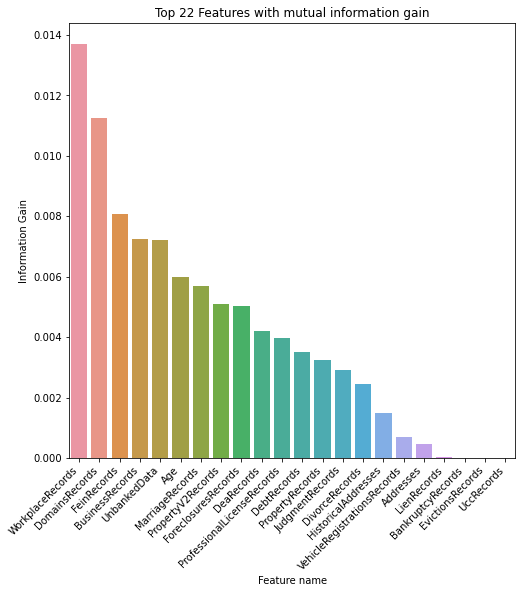

In [35]:
feature_imp = pd.DataFrame(fs.scores_, columns=['Score'], index=X.columns)
top22_feature = feature_imp.nlargest(n=22, columns=['Score'])

plt.figure(figsize=(8,8))
g = sns.barplot(x=top22_feature.index, y=top22_feature['Score'])
p = plt.title('Top 22 Features with mutual information gain')
p = plt.xlabel('Feature name')
p = plt.ylabel('Information Gain')
p = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

<Figure size 1080x1080 with 0 Axes>

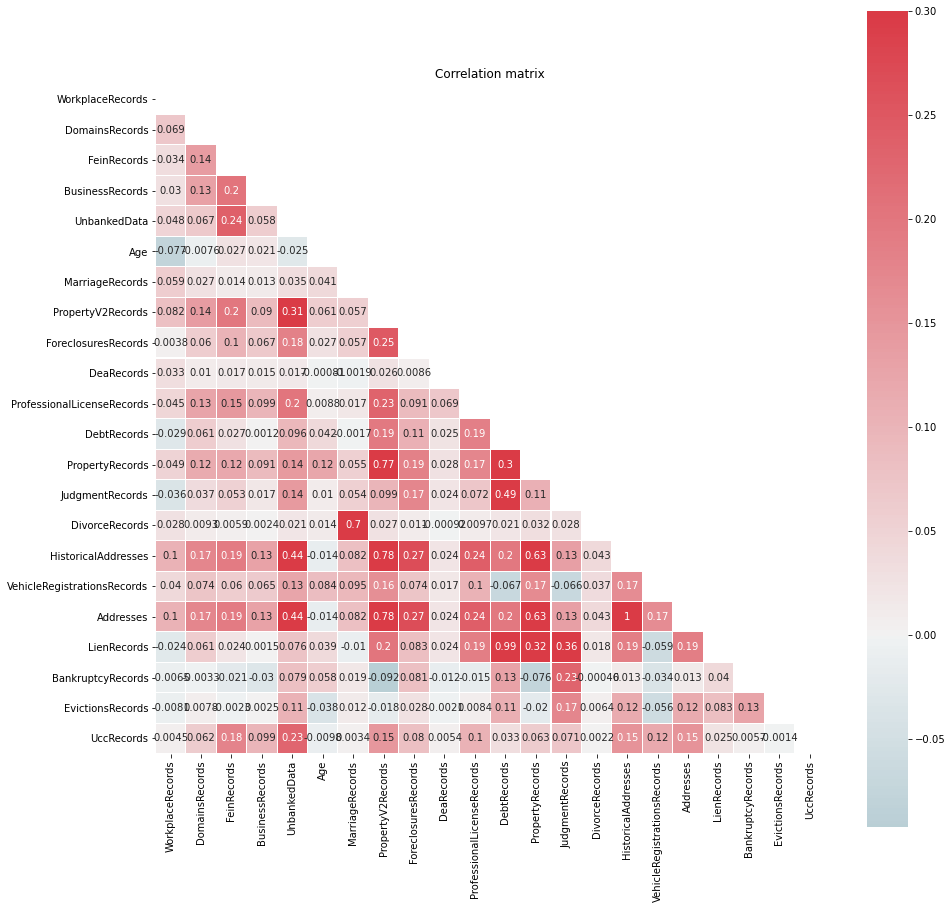

In [36]:
# Finding and plotting the correlation matrix for top22 features

cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(15, 15))
corr = X[top22_feature.index].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

g = sns.heatmap(corr, annot=True, mask=mask, vmax=0.3, center=0, cmap=cmap, square=True, linewidths=0.05)
p = plt.title('Correlation matrix')

In [37]:
X = X[top22_feature.index]
X.drop(labels=['WorkplaceRecords', 'ProfessionalLicenseRecords', 'DomainsRecords', 'FeinRecords', 'DivorceRecords', 'DeaRecords'], axis=1, inplace=True)

# Rearranging the columns
X = X[['Age', 'BankruptcyRecords', 'BusinessRecords', 'EvictionsRecords', 'ForeclosuresRecords', 'JudgmentRecords', 'LienRecords', 'MarriageRecords', 'PropertyRecords', 'VehicleRegistrationsRecords', 'PropertyV2Records', 'UccRecords', 'UnbankedData', 'Addresses', 'HistoricalAddresses', 'DebtRecords']]

# Feature Scaling

In [38]:
X.head()

,Age,BankruptcyRecords,BusinessRecords,EvictionsRecords,ForeclosuresRecords,JudgmentRecords,LienRecords,MarriageRecords,PropertyRecords,VehicleRegistrationsRecords,PropertyV2Records,UccRecords,UnbankedData,Addresses,HistoricalAddresses,DebtRecords
0,67,0,0,0,0,0,0,1,10,1,0,0,1,3,2,0
1,113,0,0,0,0,0,0,0,8,0,1,0,1,6,5,0
2,58,0,4,0,0,2,5,1,20,24,3,0,4,11,10,7
3,59,3,0,0,1,3,0,0,10,1,1,0,3,8,7,6
4,81,0,0,0,0,0,0,2,10,2,1,0,3,13,12,0


In [39]:
from sklearn.preprocessing import StandardScaler
X_prev = X.copy()

sc_VehicleRegistrationsRecords = StandardScaler()
X['VehicleRegistrationsRecords'] = sc_VehicleRegistrationsRecords.fit_transform(X[['VehicleRegistrationsRecords']])

sc_PropertyRecords = StandardScaler()
X['PropertyRecords'] = sc_PropertyRecords.fit_transform(X[['PropertyRecords']])

sc_HistoricalAddresses = StandardScaler()
X['HistoricalAddresses'] = sc_HistoricalAddresses.fit_transform(X[['HistoricalAddresses']])

sc_Addresses = StandardScaler()
X['Addresses'] = sc_Addresses.fit_transform(X[['Addresses']])

<Figure size 576x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

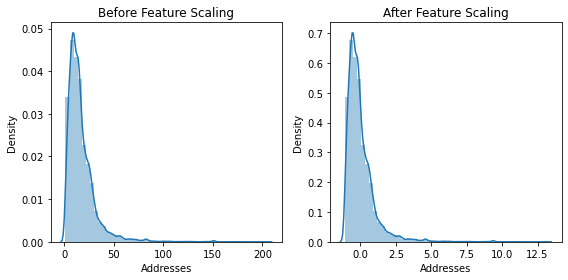

In [40]:
# Plotting Addresses before & after feature scaling
plt.figure(figsize=(8, 4))

# 1-row, 2-column, go to the first subplot
plt.subplot(1, 2, 1)
g = sns.distplot(a=X_prev['Addresses'])
p = plt.title('Before Feature Scaling')

# 1-row, 2-column, go to the second subplot
plt.subplot(1, 2, 2)
g = sns.distplot(a=X['Addresses'])
p = plt.title('After Feature Scaling')

plt.tight_layout()
plt.show()

# Model Building and Evaluation

In [41]:
from sklearn.model_selection import cross_val_score

In [42]:
# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
cv = cross_val_score(lr, X, y, cv=10, scoring='neg_root_mean_squared_error')
print('--- Average NRMSE: {} ---'.format(round(cv.mean(), 3)))
print('Standard Deviation: {}'.format(round(cv.std(), 3)))

--- Average NRMSE: -0.482 ---
Standard Deviation: 0.029


In [43]:
# Fitting Lasso Regression to the Training set
from sklearn.linear_model import Lasso
lasso = Lasso()
cv = cross_val_score(lasso, X, y, cv=10, scoring='neg_root_mean_squared_error')
print('--- Average NRMSE: {} ---'.format(round(cv.mean(), 3)))
print('Standard Deviation: {}'.format(round(cv.std(), 3)))

--- Average NRMSE: -0.553 ---
Standard Deviation: 0.004


In [44]:
# Fitting Random Forest to the Training set
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
cv = cross_val_score(rf, X, y, cv=10, scoring='neg_root_mean_squared_error')
print('--- Average NRMSE: {} ---'.format(round(cv.mean(), 3)))
print('Standard Deviation: {}'.format(round(cv.std(), 3)))

--- Average NRMSE: -0.143 ---
Standard Deviation: 0.049


In [45]:
# Fitting Gradient Boosting to the Training set
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
cv = cross_val_score(gb, X, y, cv=10, scoring='neg_root_mean_squared_error')
print('--- Average NRMSE: {} ---'.format(round(cv.mean(), 3)))
print('Standard Deviation: {}'.format(round(cv.std(), 3)))

--- Average NRMSE: -0.477 ---
Standard Deviation: 0.009


In [46]:
# Fitting Random Forest and Gradient Boosting to Voting Regressor
from sklearn.ensemble import VotingRegressor
vr = VotingRegressor([('random_forest', rf), ('gradient_boosting', gb)], weights=[2,1])
cv = cross_val_score(vr, X, y, cv=10, scoring='neg_root_mean_squared_error')
print('--- Average NRMSE: {} ---'.format(round(cv.mean(), 3)))
print('Standard Deviation: {}'.format(round(cv.std(), 3)))

--- Average NRMSE: -0.226 ---
Standard Deviation: 0.036


# Making Predictions

In [47]:
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor()

In [48]:
def predict_RESPONSE(Age, BankruptcyRecords, BusinessRecords, EvictionsRecords, ForeclosuresRecords, JudgmentRecords, LienRecords, MarriageRecords, PropertyRecords, VehicleRegistrationsRecords, PropertyV2Records, UccRecords, UnbankedData, Addresses, HistoricalAddresses, DebtRecords):

  prediction_input = list()

  prediction_input.append(Age)
  prediction_input.append(BankruptcyRecords)
  prediction_input.append(BusinessRecords)
  prediction_input.append(EvictionsRecords)
  prediction_input.append(ForeclosuresRecords)
  prediction_input.append(JudgmentRecords)
  prediction_input.append(LienRecords)
  prediction_input.append(MarriageRecords)
  
  prediction_input.append(sc_PropertyRecords.transform(np.array(PropertyRecords).reshape(1, -1)))
  prediction_input.append(sc_VehicleRegistrationsRecords.transform(np.array(VehicleRegistrationsRecords).reshape(1, -1)))

  prediction_input.append(PropertyV2Records)
  prediction_input.append(UccRecords)
  prediction_input.append(UnbankedData)

  prediction_input.append(sc_Addresses.transform(np.array(Addresses).reshape(1, -1)))
  prediction_input.append(sc_HistoricalAddresses.transform(np.array(HistoricalAddresses).reshape(1, -1)))

  prediction_input.append(DebtRecords)

  return rf.predict([prediction_input])[0]

In [49]:
# Prediction 1
# Input sequence:
# Age, BankruptcyRecords, BusinessRecords, EvictionsRecords, ForeclosuresRecords, JudgmentRecords, LienRecords, MarriageRecords, PropertyRecords, VehicleRegistrationsRecords, PropertyV2Records, UccRecords, UnbankedData, Addresses, HistoricalAddresses, DebtRecords

RESPONSE = predict_RESPONSE(56, 0, 0, 0, 0, 0, 0, 0, 277, 9, 17, 0, 2, 47, 46, 0)
print('Predicted RESPONSE: {}'.format(RESPONSE))

Predicted RESPONSE: 0.34547619047619044


In [50]:
# Prediction 2
# Input sequence:
# Age, BankruptcyRecords, BusinessRecords, EvictionsRecords, ForeclosuresRecords, JudgmentRecords, LienRecords, MarriageRecords, PropertyRecords, VehicleRegistrationsRecords, PropertyV2Records, UccRecords, UnbankedData, Addresses, HistoricalAddresses, DebtRecords

RESPONSE = predict_RESPONSE(71, 1, 0, 0, 0, 2, 0, 1, 57, 46, 11, 0, 2, 32, 31, 3)
print('Predicted RESPONSE: {}'.format(RESPONSE))

Predicted RESPONSE: 0.86


In [51]:
# Prediction 3
# Input sequence:
# Age, BankruptcyRecords, BusinessRecords, EvictionsRecords, ForeclosuresRecords, JudgmentRecords, LienRecords, MarriageRecords, PropertyRecords, VehicleRegistrationsRecords, PropertyV2Records, UccRecords, UnbankedData, Addresses, HistoricalAddresses, DebtRecords

RESPONSE = predict_RESPONSE(58, 0, 0, 0, 0, 0, 0, 0, 30, 2, 1, 0, 1, 13, 12, 0)
print('Predicted RESPONSE: {}'.format(RESPONSE))

Predicted RESPONSE: 1.0


In [52]:
# Prediction 4
# Input sequence:
# Age, BankruptcyRecords, BusinessRecords, EvictionsRecords, ForeclosuresRecords, JudgmentRecords, LienRecords, MarriageRecords, PropertyRecords, VehicleRegistrationsRecords, PropertyV2Records, UccRecords, UnbankedData, Addresses, HistoricalAddresses, DebtRecords

RESPONSE = predict_RESPONSE(61, 0, 2, 0, 0, 0, 0, 0, 39, 22, 6, 0, 2, 24, 23, 0)
print('Predicted RESPONSE: {}'.format(RESPONSE))

Predicted RESPONSE: 0.0


In [53]:
# Prediction 5
# Input sequence:
# Age, BankruptcyRecords, BusinessRecords, EvictionsRecords, ForeclosuresRecords, JudgmentRecords, LienRecords, MarriageRecords, PropertyRecords, VehicleRegistrationsRecords, PropertyV2Records, UccRecords, UnbankedData, Addresses, HistoricalAddresses, DebtRecords

RESPONSE = predict_RESPONSE(68, 0, 0, 0, 0, 28, 1, 0, 14, 0, 1, 0, 2, 11, 10, 29)
print('Predicted RESPONSE: {}'.format(RESPONSE))

Predicted RESPONSE: 0.01


In [54]:
# Prediction 6
# Input sequence:
# Age, BankruptcyRecords, BusinessRecords, EvictionsRecords, ForeclosuresRecords, JudgmentRecords, LienRecords, MarriageRecords, PropertyRecords, VehicleRegistrationsRecords, PropertyV2Records, UccRecords, UnbankedData, Addresses, HistoricalAddresses, DebtRecords

RESPONSE = predict_RESPONSE(37, 0, 1, 0, 0, 0, 4, 0, 13, 0, 4, 0, 2, 21, 20, 4)
print('Predicted RESPONSE: {}'.format(RESPONSE))

Predicted RESPONSE: 0.0
